In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import xarray as xr
import dask

In [3]:
# Load separately
t2m = xr.open_dataset('/content/drive/MyDrive/rainfall dataset/ERA5_2mtemp_1960-2024.nc')
r = xr.open_dataset('/content/drive/MyDrive/rainfall dataset/ERA5_Rh_1960-2024.nc')
tp = xr.open_dataset('/content/drive/MyDrive/rainfall dataset/ERA5_Tp_1960-2024.nc')
u = xr.open_dataset('/content/drive/MyDrive/rainfall dataset/ERA5_u-wind_1960-2024.nc')

# Merge by coordinates
ds = xr.merge([t2m, r, tp, u] , compat='override')
ds = ds.sel(
    valid_time=slice('2023-01-01', '2024-12-31'),
)
print(ds)

<xarray.Dataset> Size: 197MB
Dimensions:         (valid_time: 731, latitude: 140, longitude: 120,
                     pressure_level: 1)
Coordinates:
    number          int64 8B ...
  * valid_time      (valid_time) datetime64[ns] 6kB 2023-01-01 ... 2024-12-31
  * latitude        (latitude) float64 1kB 37.95 37.7 37.45 ... 3.7 3.45 3.2
  * longitude       (longitude) float64 960B 67.6 67.85 68.1 ... 97.1 97.35
    expver          (valid_time) <U4 12kB ...
  * pressure_level  (pressure_level) float64 8B 100.0
Data variables:
    t2m             (valid_time, latitude, longitude) float32 49MB ...
    r               (valid_time, pressure_level, latitude, longitude) float32 49MB ...
    tp              (valid_time, latitude, longitude) float32 49MB ...
    u               (valid_time, pressure_level, latitude, longitude) float32 49MB ...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:        

In [4]:
t2m = t2m - 273.15


In [5]:
ds['r'] = ds['r'].clip(max=100)

In [7]:
# Calculate daily rainfall from cumulative values
ds['tp_daily'] = ds['tp'].clip(min=0)  # Remove negatives, if any

# Convert to mm
ds['tp_daily'] = ds['tp_daily'] * 1000
ds['tp_daily'].attrs['units'] = 'mm'

In [8]:
tp_daily = ds['tp_daily']

In [9]:
# === 5. Align time and spatial dimensions ===
t2m = t2m.sel(valid_time=tp_daily.valid_time)
r   = r.sel(valid_time=tp_daily.valid_time)
u   = u.sel(valid_time=tp_daily.valid_time)

In [10]:
# === 8. Flatten spatial-temporal grid for ML ===
latitude = ds['latitude'].values
longitude = ds['longitude'].values
valid_time = ds['valid_time'].values

In [11]:
# === 2. Flatten each variable individually ===
t2m_flat = ds['t2m'].data.flatten()   # Dask array
r_flat   = ds['r'].data.flatten()
u_flat   = ds['u'].data.flatten()
tp_flat  = ds['tp_daily'].data.flatten()

In [12]:
import numpy as np

# Repeat lat/lon grids
lat_grid = np.repeat(latitude[:, None], len(longitude), axis=1)  # (lat, lon)
lon_grid = np.tile(longitude, (len(latitude), 1))                # (lat, lon)'''

In [13]:
import pandas as pd
import numpy as np

# Assume ds_merged contains your aligned variables
times = pd.to_datetime(ds['valid_time'].values)  # use the time dimension that matches t2m_flat

# How many grid points per time step?
num_points_per_time = len(ds['latitude']) * len(ds['longitude'])

# Repeat each timestamp for all grid points
valid_time_array = np.repeat(times.values, num_points_per_time)

print(len(valid_time_array), len(t2m_flat))  # should now match exactly

# Convert to month/day or numeric values
month_array = np.array([t.month for t in pd.to_datetime(valid_time_array)])
day_of_year_array = np.array([t.dayofyear for t in pd.to_datetime(valid_time_array)])

print(len(valid_time_array))


12280800 12280800
12280800


In [14]:
print(len(t2m_flat), len(r_flat), len(u_flat))
print(len(np.tile(lat_grid, len(valid_time)).flatten()))

12280800 12280800 12280800
12280800


In [15]:
print(len(valid_time_array))


12280800


In [16]:
X = np.stack([
    t2m_flat,
    r_flat,
    u_flat,
    np.tile(lat_grid, len(valid_time)).flatten(),
    np.tile(lon_grid, len(valid_time)).flatten(),
    month_array,
    day_of_year_array
], axis=1)

print(X.shape)

(12280800, 7)


In [17]:
# Ensure it's 2D
X = X.reshape(X.shape[0], -1)

In [18]:
y_log = np.log1p(tp_flat)

In [19]:
np.any(y_log < 0)


np.False_

In [20]:
print(y_log[:100])

[0.        0.        0.        1.3431834 1.3431834 0.        0.
 0.        0.        0.        0.        1.07744   2.2661984 2.8473637
 2.784961  2.1517148 1.3431834 0.        1.07744   2.0419374 2.5928612
 2.2661984 0.        0.6387278 0.6387278 0.6387278 1.5839769 1.8964859
 2.0419374 2.0419374 1.7523898 0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        2.1517148 2.784961
 3.35746   4.030398  4.588071  4.441398  3.4794369 2.8979175 2.0419374
 1.07744   0.        0.        0.        0.        0.        0.
 0.6387278 0.6387278 0.        0.        0.        0.        0.
 0.        0.       ]


In [21]:
print("✅ Features and targets prepared.")
print("X shape:", X.shape)
print("y shape:", y_log.shape)

✅ Features and targets prepared.
X shape: (12280800, 7)
y shape: (12280800,)


In [22]:
print("✅ Preprocessing done!")
print(f"Input shape: {X.shape}, Target shape: {y_log.shape}")

✅ Preprocessing done!
Input shape: (12280800, 7), Target shape: (12280800,)


In [23]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
from scipy.stats import randint, uniform
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt


In [24]:
# 5. Create sequences: past_seq days → next day's rainfall
# -----------------
past_seq = 90
X_seq, y_log_seq = [], []
n_time = ds['tp_daily'].shape[0]  # Calculate n_time from the shape of tp_daily
for t in range(past_seq, n_time):
    # Assuming features and target are defined earlier in your notebook
    # Replace with your actual features and target variables
    # For example, if X is your features and tp_daily is your target:
    features = X # Replace with your actual features
    target = tp_daily # Replace with your actual target

    X_seq.append(features[t-past_seq:t])  # shape: (past_seq, features)
    y_log_seq.append(target[t])               # rainfall at time t

X_seq = np.array(X_seq)  # (samples, past_seq, features)
y_log_seq = np.array(y_log_seq)  # (samples, grid_points)

# For simplicity: predict average rainfall across region
y_log_seq = y_log_seq.mean(axis=1)

In [25]:
from tensorflow.keras import layers, Model
from sklearn.model_selection import train_test_split

# 7. Transformer model for feature extraction
# -----------------
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x)
    res = x + inputs

    x = layers.Dense(ff_dim, activation="relu")(res)
    x = layers.Dropout(dropout)(x)
    x = layers.Dense(inputs.shape[-1])(x)
    return layers.LayerNormalization(epsilon=1e-6)(x + res)

n_features = X_seq.shape[-1] # Calculate n_features from the shape of X_seq
inp = layers.Input(shape=(past_seq, n_features))
x = transformer_encoder(inp, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)
x = layers.GlobalAveragePooling1D()(x)  # flatten temporal features
transformer_model = Model(inputs=inp, outputs=x)

In [26]:
X_train, X_test, y_log_train, y_log_test = train_test_split(X_seq, y_log_seq, test_size=0.2, shuffle=False)

In [27]:
train_features = transformer_model.predict(X_train, batch_size=32)
test_features = transformer_model.predict(X_test, batch_size=32)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


In [29]:
import tensorflow as tf

# Transformer model definition
transformer_model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu')
])

# Optimizer for Transformer
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

transformer_model.compile(
    optimizer=optimizer,
    loss='mse',
    metrics=['mae']
)


In [ ]:
final_model = XGBRegressor(
    colsample_bytree=0.9242271325136076,
    gamma=0.5431252624111691,
    learning_rate=0.28364924523059926,
    max_depth=9,
    min_child_weight=9,
    n_estimators=456,
    reg_alpha=0.08550508067834788,
    reg_lambda=1.833087491721022,
    subsample=0.9398475058630121,
    random_state=42,
    n_jobs=-1,
    objective='reg:squarederror',
    epoch= 200
)

final_model.fit(X_train, y_log_train)

In [31]:
y_pred_final = final_model.predict(X_test)
print(y_pred_final)

[3.5143254 3.5546982 3.6263916 ... 8.984718  8.472759  5.6040955]


In [32]:
mse = mean_squared_error(y_log_test, y_pred_final)
mae = mean_absolute_error(y_log_test, y_pred_final)
r2 = r2_score(y_log_test, y_pred_final)


In [34]:
print(f"Mean Squared Error (MSE): {mse:.3f}")
print(f"Mean Absolute Error (MAE): {mae:.3f}")
print(f"R² Score: {r2:.3f}")

Mean Squared Error (MSE): 2.674
Mean Absolute Error (MAE): 3.361
R² Score: 0.678


In [ ]:
y_pred_final_normal = np.expm1(y_pred_final)
y_pred_final_normal = np.clip(y_pred_final_normal, 0, None)
print(y_pred_final_normal)

In [36]:
np.any(y_pred_final_normal < 0)


np.False_

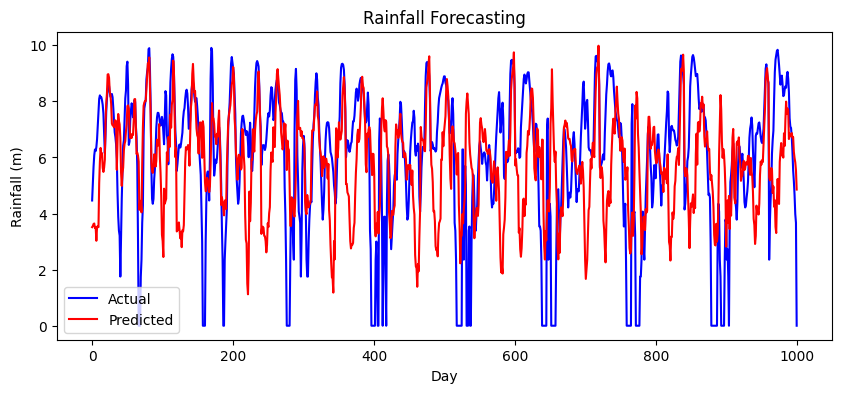

In [37]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(10, 4))

# Convert to 1D arrays
actual_line = np.ravel(y_log_test[:1000])  # flatten
predicted_line = np.ravel(y_pred_final[:1000])

# Or use mean if multiple features per day
# actual_line = np.mean(y_log_test[:100], axis=1)
# predicted_line = np.mean(y_pred_final[:100], axis=1)

plt.plot(actual_line, label="Actual", color='blue')
plt.plot(predicted_line, label="Predicted", color='red')

plt.title("Rainfall Forecasting")
plt.xlabel("Day")
plt.ylabel("Rainfall (m)")
plt.legend()
plt.show()

In [38]:
'''import seaborn as sns

sns.boxplot(x=y_pred_final_normal)
plt.show()'''

'import seaborn as sns\n\nsns.boxplot(x=y_pred_final_normal)\nplt.show()'

In [39]:
#save the model

import joblib
joblib.dump(final_model, 'Rainfall_model2.pkl')

['Rainfall_model2.pkl']

In [40]:
#load the saved model

import joblib

# Load the model
model = joblib.load('/content/Rainfall_model2.pkl')
print(model)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.9242271325136076, device=None,
             early_stopping_rounds=None, enable_categorical=False, epoch=200,
             eval_metric=None, feature_types=None, feature_weights=None,
             gamma=0.5431252624111691, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.28364924523059926,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=9, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=456, n_jobs=-1, ...)


In [41]:
with open("Rainfall_model2.pkl", "rb") as f:
    print(f.read(20))

b'\x80\x04\x95~\x03\x00\x00\x00\x00\x00\x00\x8c\x0fxgboost'


In [42]:
import pickle

In [43]:
with open("Rainfall_model2.pkl", "wb") as f:
  pickle.dump(model, f)

In [44]:
with open("Rainfall_model2.pkl", "rb") as f:
    model = pickle.load(f)

In [45]:
import pickle

# Load the model
with open("/content/Rainfall_model2.pkl", "rb") as file:
    model = pickle.load(file)

# Example: Predict on new/preprocessed test data
predictions = y_pred_final_normal
print("Predictions:", predictions[:10])

Predictions: [32.593258 33.977264 36.57698  37.246044 31.520864 32.87699  19.668438
 33.083126 33.628944 32.54462 ]


In [46]:
predictions = np.abs(predictions)

In [47]:
np.any(predictions < 0)


np.False_

In [48]:
np.sum(predictions < 0)


np.int64(0)

In [50]:
pip install streamlit

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 34.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 53.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 5.8 MB/s eta 0:00:00


In [51]:
pip install pyngrok

In [52]:
# Create the Streamlit app file
with open("app.py", "w") as f:
    f.write('''

# streamlit_app.py
import streamlit as st
import pickle
import numpy as np
from geopy.geocoders import Nominatim
import datetime

# Load the trained model
model = pickle.load(open("/content/Rainfall_model2.pkl", "rb"))

st.title("🌧️ Rainfall Forecasting and Crop Advisory")
st.write("### Enter today's data:")

today = datetime.date.today()
max_date = today + datetime.timedelta(days=90)  # 3 months from today

# Input fields
t2m = st.number_input("🌡️ Temperature (°C)")
r = st.number_input("💧 Relative Humidity (%)")
u = st.number_input("🌬️ Wind Speed (m/s)")
latitude = st.number_input("📍 Latitude (37.95 - 3.2)")
longitude = st.number_input("📍 Longitude (67.6 - 97.35)")

# Date input
Date = st.date_input(
    "📅 Select Date",
    value=today,       # Default is today
    min_value=today,   # Can't pick a past date
    max_value=max_date # Limit to next 3 months
)

# Extract month and day_of_year from selected date
month = Date.month
day_of_year = Date.timetuple().tm_yday

# Crop selection
st.write("### Select Crop to Check Impact")
crops = ["Rice", "Wheat", "Maize", "Cotton", "Pulses"]
selected_crop = st.selectbox("🌾 Select Crop", crops)

if st.button("🚀 Predict Rainfall & Show Impact"):
    # Features for selected date
    today_features = np.array([[t2m, r, u, latitude, longitude, month, day_of_year]])
    result_today = model.predict(today_features)
    predicted_today = result_today.flatten()[0]

    # Features for 3 months later
    future_date = Date + datetime.timedelta(days=90)
    future_month = future_date.month
    future_day_of_year = future_date.timetuple().tm_yday
    future_features = np.array([[t2m, r, u, latitude, longitude, future_month, future_day_of_year]])
    result_future = model.predict(future_features)
    predicted_future = result_future.flatten()[0]

    st.success(f"📅 {Date} — Predicted Rainfall: {predicted_today:.2f} mm")
    st.success(f"📅 {future_date} — Predicted Rainfall: {predicted_future:.2f} mm")

    # Location info
    geolocator = Nominatim(user_agent="geoapi")
    location = geolocator.reverse((latitude, longitude), language='en')
    if location:
        address = location.raw.get('address', {})
        state = address.get('state', 'Unknown')
        district = address.get('county', address.get('district', 'Unknown'))

        st.write("📍 **Predicted Location:**")
        st.write(f"State: `{state}`")
        st.write(f"District: `{district}`")
    else:
        st.warning("⚠️ Could not determine location from coordinates.")

    # Crop Impact Assessment
    def assess_rainfall_effect(rainfall, crop):
        if crop == "Rice":
            if rainfall < 6:
                return "🚨 Low rainfall! Rice may require irrigation."
            elif 6 <= rainfall <= 15:
                return "✅ Ideal rainfall for rice. Good yield expected."
            else:
                return "⚠️ Excessive rainfall! Risk of waterlogging."

        elif crop == "Wheat":
            if rainfall < 2:
                return "🚨 Too dry for wheat. Irrigation recommended."
            elif 2 <= rainfall <= 7:
                return "✅ Suitable rainfall for wheat."
            else:
                return "⚠️ Excess rain may harm wheat growth."

        elif crop == "Maize":
            if rainfall < 4:
                return "🚨 Low rainfall. Poor germination likely."
            elif 4 <= rainfall <= 11:
                return "✅ Good for maize growth."
            else:
                return "⚠️ High rainfall. Risk of fungal diseases."

        elif crop == "Cotton":
            if rainfall < 4:
                return "🚨 Insufficient water for cotton."
            elif 4 <= rainfall <= 8:
                return "✅ Optimal rainfall for cotton."
            else:
                return "⚠️ Water stress may harm cotton quality."

        elif crop == "Pulses":
            if rainfall < 2:
                return "🚨 Not enough rainfall for pulses."
            elif 2 <= rainfall <= 7:
                return "✅ Rainfall is good for pulses."
            else:
                return "⚠️ Pulses may face disease pressure due to excess water."

        return "ℹ️ No recommendation available."

    # Crop impact for today
    st.subheader("🌱 Today's Crop Advisory")
    today_advice = assess_rainfall_effect(predicted_today, selected_crop)
    st.info(today_advice)

    # Crop impact for 3 months later
    st.subheader("🌱 3 Months Later Crop Advisory")
    future_advice = assess_rainfall_effect(predicted_future, selected_crop)
    st.info(future_advice)
    ''')


In [53]:
!ngrok config add-authtoken 30MWdHzKWLcpCOUUgBkyhfAAWp5_29r43E9WnjP2V3c2AAbgR

Authtoken saved to configuration file: /root/.config/ngrok/ngrok.yml


In [54]:
import subprocess
import threading
import time
from pyngrok import ngrok

# Kill old tunnels
ngrok.kill()

# Start Streamlit app in background
def run_app():
    subprocess.call(["streamlit", "run", "app.py"])

thread = threading.Thread(target=run_app)
thread.start()

# Wait for the app to launch
time.sleep(5)

# Open ngrok tunnel
public_url = ngrok.connect(8501, "http")
print(f"🚀 Your Streamlit app is live at: {public_url}")

🚀 Your Streamlit app is live at: NgrokTunnel: "https://103f61d0f799.ngrok-free.app" -> "http://localhost:8501"
